In [1]:
%load_ext autoreload
%autoreload 2

from evaluation_scripts.base import load_json, get_base_pathes
import os
from evaluation_scripts.base import load_pickle_obj
from model_scripts.sensitivity_evaluation import SensitivityAnalysis, summarize_evaluations, count_strategy, get_shared
from model_scripts.wins_and_losses import WinsAndLosses, set_title, set_common_ylabel
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd


_, base = get_base_pathes()
path = os.path.join(base, "sensitivity_sim")

name_add = "_clean_no_preex"

In [2]:
sensitivity = SensitivityAnalysis(path, parameter_names = ["turnover",
                                "infection", "cA", "cB", "cS", "cU", "cAB"], name_add = name_add)
reload = True
if reload:
    sensitivity.load()
else:
    sims = pd.read_pickle(os.path.join(path, "sensitivity_sim"+name_add+".pkl"))
    pars = pd.read_pickle(os.path.join(path, "sensitivity_par"+name_add+".pkl"))
    sensitivity.evaluate_parameter_sets(sims, pars)
    sensitivity.save()

In [3]:
df = summarize_evaluations(sensitivity.evaluations)


results = []
for strategy in ["Combination", "Cycling", "Mixing", "Mono A", "Mono B"]:
    results.append(count_strategy(df, strategy))
results = pd.DataFrame().from_records(results)
results = results.set_index("strategy")

insignificant = df.apply(lambda x: get_shared(x, "worst_", None), axis = 1).sum()

print("Num of insignificant scenarios: ", insignificant)

results

Num of insignificant scenarios:  8


,single_winner,single_loser,loser,winner
strategy,,,,
Combination,8704,0,0,9598
Cycling,8,6,1480,616
Mixing,0,4,1966,200
Mono A,382,2753,5571,562
Mono B,0,4367,6510,141


In [4]:
results_rel = results.copy()
results_rel = results_rel * 100 / len(sensitivity.evaluations)
results_rel

,single_winner,single_loser,loser,winner
strategy,,,,
Combination,87.04,0.00,0.00,95.98
Cycling,0.08,0.06,14.80,6.16
Mixing,0.00,0.04,19.66,2.00
Mono A,3.82,27.53,55.71,5.62
Mono B,0.00,43.67,65.10,1.41


In [5]:
color_1 = ["#FFA500", "#FF8C00", "#FF6347"]
color_2 = ["#00CED1", "#40E0D0", "#20B2AA"]
colors = {
    "single_win":"#5779B7", 
    "total_win":"#8DACD6",
    "single_loss":"#B74A4A", 
    "total_loss":"#D68A8A",
}

file_path = os.path.join(base, "summary", "exp_anova_no_notreat.json")
exp_results = load_json(file_path)
exp_results = [exp_results[0], exp_results[2]]

In [6]:
exp_results

[{'comment': '',
  'date': '20220412',
  'loser': ['Mono B'],
  'pValue': 3.3383202724642855e-12,
  'winner': ['Combination']},
 {'comment': '',
  'date': '20210417',
  'loser': ['Mono A'],
  'pValue': 5.302216014270491e-14,
  'winner': ['Combination', 'Cycling', 'Mixing']}]

/Users/malte/ETH-Documents/TSP-Collection/TSPlasmids_main/JupyterScripts/model_scripts/wins_and_losses.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(int(label)) for label in ax.get_yticks()])


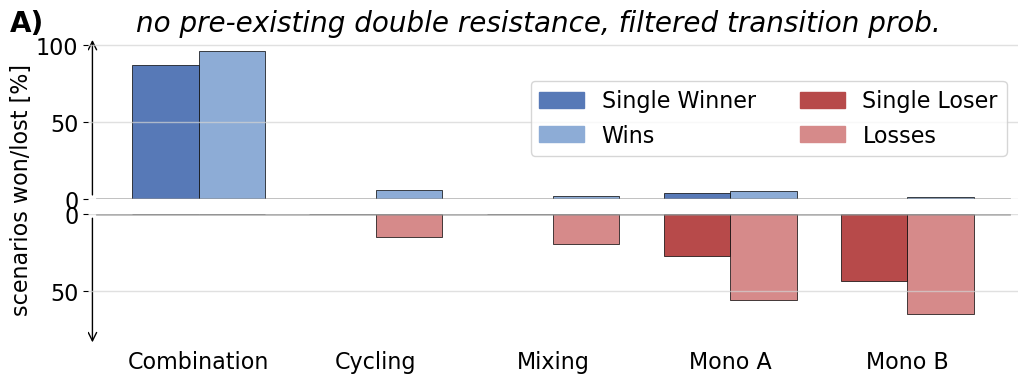

In [7]:
WandL = WinsAndLosses(results_rel, path, colors, fontsize=16, axes_label_fontsize=16, y_label_x = -.1, figsize=(12, 4))
#WandL.add_exp_results(exp_results)
fig, axs = WandL.plot(title = None, legend = True)
set_title(fig, "A)", "no pre-existing double resistance, filtered transition prob.",  title_y = .95)
set_common_ylabel(fig, axs, "scenarios won/lost [%]")
WandL.save(path, name_add = name_add)
plt.show()

In [8]:
results_df = results_rel.copy()
results_df = results_df.rename(columns=lambda x: x + " [\%]")
results_df = results_df.join(results)
results_df.columns = [col.replace('_', ' ') for col in results_df.columns]
results_df.to_latex(os.path.join(base, "tables", "win_loss_statistic"+name_add+".tex"),
                   float_format="%.2f")
results_df

,single winner [\%],single loser [\%],loser [\%],winner [\%],single winner,single loser,loser,winner
strategy,,,,,,,,
Combination,87.04,0.00,0.00,95.98,8704,0,0,9598
Cycling,0.08,0.06,14.80,6.16,8,6,1480,616
Mixing,0.00,0.04,19.66,2.00,0,4,1966,200
Mono A,3.82,27.53,55.71,5.62,382,2753,5571,562
Mono B,0.00,43.67,65.10,1.41,0,4367,6510,141


In [9]:
insignificant

8

In [10]:
from figures import Figure, styles
import matplotlib as mpl

mpl.rcParams['text.usetex'] = False

presentation = Figure(styles["presentation"])
presentation.add_folder("/Users/malte/Documents/Meetings/Smiddy")
presentation

/Users/malte/ETH-Documents/TSP-Collection/TSPlasmids_main/JupyterScripts/model_scripts/wins_and_losses.py:219: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(int(label)) for label in ax.get_yticks()])


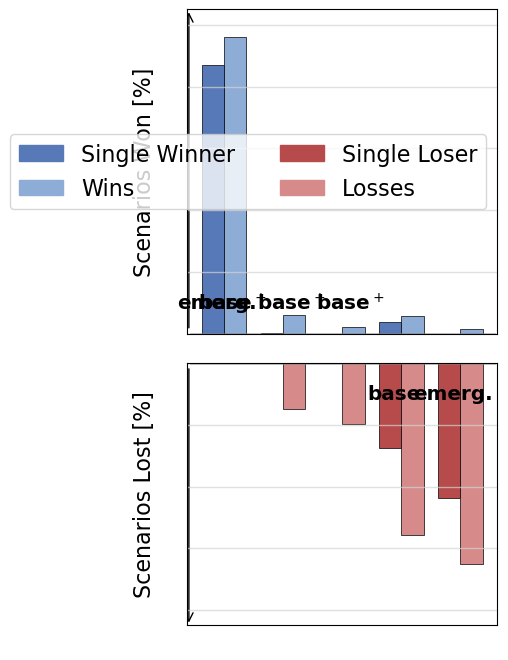

In [11]:
WandL = WinsAndLosses(results_rel, path, colors, fontsize=16, axes_label_fontsize=16, y_label_x = -.1)
WandL.add_exp_results(exp_results)
WandL.plot(title = "no preexisting double resistance", legend = True)
presentation.apply_style(WandL.axs[0])
presentation.apply_style(WandL.axs[1])
WandL.axs[0].set_title("")
WandL.axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.savefig("/Users/malte/Documents/Meetings/Smiddy/sensitivity.png", dpi = 300)
plt.show()
